*Excercise in Deep Learning*
*Regression*

This example goes through:

- create a generator for *1e8 data points*!  using a "generator"
- Use a neural network to fit a model
- Show how error of fit changes with training epochs
- Show that the trained coefficients are the slope and intercept

required python software packages (install with pip):
- numpy
- tensorflow
- matplotlib

*Conclusions*

few standard least-squares fit programs (e.g. R ) will handle 1e8 data points in about 4 minutes.  Deep learning is
very efficient for this kind of large data set.

The answer produced is quite accurate in 1 training epoch due to the data size.


In [1]:
""" some variables you can experiment with to see how they affect the results """

nrows = int(1e8)  # number of rows for example, change this to see impact
                  # of data size
    
numEpochs = 100   # number of training steps.

batch_size = 512  # training batch size

slope = 3.0       # slope of line to be generated
intercept = 7.0   # intercept of line
                  # you can experiment with these

#
#   with these conditions the RMS error is 0.0000, slope is 3.0000,  intercept 7.0000
#   the time was about 5-10 minutes.
#   

In [2]:
import tensorflow.keras as keras
import numpy as np

"""
In big-data situations the data won't all fit in memory.  In that case we use a generator to
feed the data to Tensorflow in batches.  The data could be read from files or other sources.

In this example we generate a large number of random data, and create a linearly correlated data
set.  This can generate an "unlimited" size data set.
"""

# implement a class of type 'keras.utils.Sequence'
# https://keras.io/api/utils/python_utils/#sequence-class
class linear_generator(keras.utils.Sequence):
    
    # initialize with batch_size and nrows - total data size
    # in a class all methods have the 'self' argument first.
    def __init__(self, batch_size, nrows):
        self.batch_size = batch_size # store batch_size in this class
        self.nrows = nrows
        self.batches = int(nrows/batch_size)
     
    # return number of batches this generator will produce
    def __len__(self):
        return self.batches
    
    
    # this method is called for each batch. In this example we ignore the
    # batch index, idx, because it is just random numbers. But in a real
    # situation you would retrieve a specific batch of data
    def __getitem__(self, idx):
        # use the numpy library to create a random list
        # of numbers beteen 0 and 1.  np.random.uniform supplies this.
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html
        x = np.random.uniform(low=0, high=1, size=self.batch_size)

        # numpy allows "overloading operators"  to allow a natural
        # syntax for multiplying and adding to a list
        y = slope*x + intercept

        # return x,y as a tuple
        return (x,y)
    

In [3]:
"""
create the Neural Network model topology, which is one layer
"""
import tensorflow as tf
import tensorflow.keras as keras

def makeModel():

    # these two lines clear out the model so you can re-run 
    # the notebook with different conditions
    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    # https://keras.io/api/models/sequential/#sequential-class
    model = keras.Sequential()
    
    # https://keras.io/api/layers/core_layers/input/
    model.add(keras.Input(shape=(1,)))
    
    # define a single layer of neurons.  There are many options that 
    # could be used here but the default are used for this simple example
    
    # https://keras.io/api/layers/core_layers/dense/
    model.add(keras.layers.Dense(units=1, name='dense_layer'))
        
    # compile the network using default options.  The Adam optimizer
    # is good for general purpose, but would probably benefit from a custom
    # learning rate for this example
    #
    # the loss is function that will be minimized in the fitting process
    # https://keras.io/api/models/model_training_apis/#compile-method
    model.compile(optimizer='Adam', loss='mean_squared_error')
    
    #show the model structure and layer size
    # the model has 2 trainable variables - enough for a perfect fit.
    model.summary()
    
    return model


In [4]:
%%time
"""
Put the elements together to generate data, make the model, and perform the training
"""


# create the random data
data = linear_generator(batch_size, nrows)
validation = linear_generator(batch_size, min(1000, nrows/4))

# print out the number of batches
tbatches = data.__len__()             # training batches
vbatches = validation.__len__()       # validation batches

print('number of training  batches',  tbatches)
print('number of validation batches', vbatches)

# create the neural network
model = makeModel()

# this will monitor the error and stop if the delta is less than min_delta
# https://keras.io/api/callbacks/early_stopping/
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


# fit the model with 500 steps.  There is a way to stop on specified change
# in error but this is a simple example.
#
# https://keras.io/api/models/model_training_apis/#fit-method
history = model.fit(
    x=data,
    validation_data=validation,
    callbacks=earlystop, # dynamic stopping
    epochs=numEpochs,     # try changing this to see how the error changes
    verbose=0,    # change this from 0-5 to get more info as the training proceeds
    )


epochs = len(history.history)
# https://keras.io/api/models/model_training_apis/#evaluate-method
loss = model.evaluate(validation)

print('\nfitting epochs ', epochs)
print('rms error of prediction %5.4f' % (np.sqrt(loss)))


number of training  batches 195312
number of validation batches 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer (Dense)          (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 959us/step - loss: 3.3901e-11

fitting epochs  2
rms error of prediction 0.0000
CPU times: user 9min 27s, sys: 55 s, total: 10min 22s
Wall time: 4min 26s


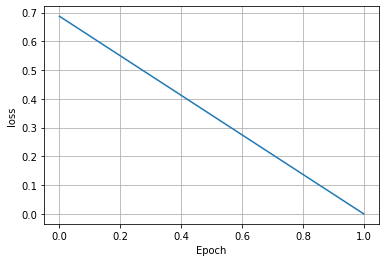

In [5]:
import matplotlib.pyplot as plt
# https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.html

plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)

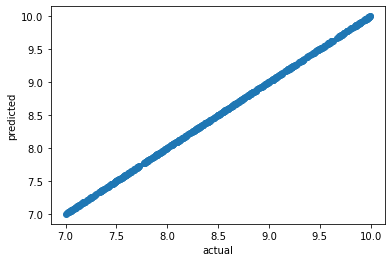

In [6]:
#
# plot predicted vs actual
# this should be a straight line with a
# slope of 1.0
x,y = validation.__getitem__(0)
predy = model.predict(x)
plt.xlabel('actual')
plt.ylabel('predicted')
s = plt.scatter(y, predy)

model.predict shape tf.Tensor([512   1], shape=(2,), dtype=int32)
shape is now tf.Tensor([512], shape=(1,), dtype=int32)

computed slope/intercept:
slope 3.0000  intercept 7.0000


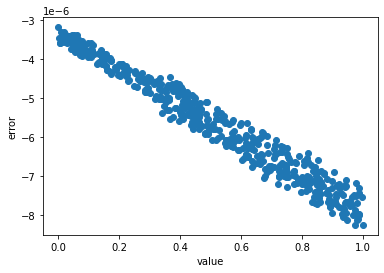

In [7]:
#
# plot error as a function of X
#
x,y = validation.__getitem__(0)
py = model.predict(x)
# the output of model.predict is this
print('model.predict shape', tf.shape(py))

# need to reshap to a normal list
py = tf.reshape(model.predict(x), len(x))
print('shape is now', tf.shape(py))

# now subtract predicted - actual y to look at errors
error = np.subtract(py, y)

#
# plot the errors
# the errors are not randomly distributed
#
plt.scatter(x, error)
plt.xlabel('value')
s = plt.ylabel('error')


#
# one can get the coefficients of the neural net.  Normally they are not very interpretable
# but since in this model there are only two, they correspond to slope and intercept
#
slope, intercept = model.get_weights()

print('\ncomputed slope/intercept:')
print('slope %5.4f  intercept %5.4f'  % (slope, intercept))